Импорт необходимых модулей

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
import json
import sys
sys.path.append('../')
import neftpy.upvt_gas as pvtg
import neftpy.upvt_np_vect as pvtv
import scipy.optimize as opt

Водопьян А.О. Хабибуллин Р.А. 2019 г. 

# Z - фактор, коэффициент сверхсжимаемости для углеводородных газов
 Коэффициент сверхсжимаемости  определяется как

$$ Z=\frac{p V}{n R T}$$
 
где $p$ — давление газа, $T$ — температура, $V$ — молярный объём, $n$ - количество молей.

Для идеального газа коэффициент сжимаемости $Z$ равен единице, и тогда получаем привычное уравнение состояния идеального газа:

$$pV = nRT$$

Для идеального газа коэффициент сжимаемости по определению равен $Z=1$. Во многих реальных приложениях требования к точности требуют учета отклонений от поведения идеального газа, т.е. поведения реального газа. Значение Z обычно увеличивается с ростом давления и уменьшается с ростом температуры. При высоких давлениях молекулы сталкиваются чаще. Это позволяет силам отталкивания между молекулами оказывать заметное влияние, делая молярный объем реального газа больше молярного объема соответствующего идеального газа, что приводит к тому, что Z больше единицы.[3] Когда давление ниже, молекулы могут свободно двигаться. В этом случае преобладают силы притяжения, поэтому $Z<1$. Чем ближе газ к критической точке или точке кипения, тем больше 
Z отклоняется от идеального случая.



# Приведенные давление и температура

Свойства различных углеводородных газов схожи между собой и могут быть обобщены с использованием приведенных давлений и температуры ([Закон соответственных состояний - википедия](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D1%81%D0%BE%D0%BE%D1%82%D0%B2%D0%B5%D1%82%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%BE%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B9))

$$P_{r} = \frac{P}{P_c}$$
$$T_{r} = \frac{T}{T_c}$$
где $p_c$ и $T_c$ критические давление и температура соответственно, которые являются функцией плотности газа и возможного наличия неуглеводородных примесей.

Для значений температур близким к критической, приведенная температура близка к единице. В этом случае поведение газа максимально отличается от идеального, что может вызывать сложности при проведении расчетов по корреляционным зависимостям. Полезно проследить когда достигаются эти условия на практике.



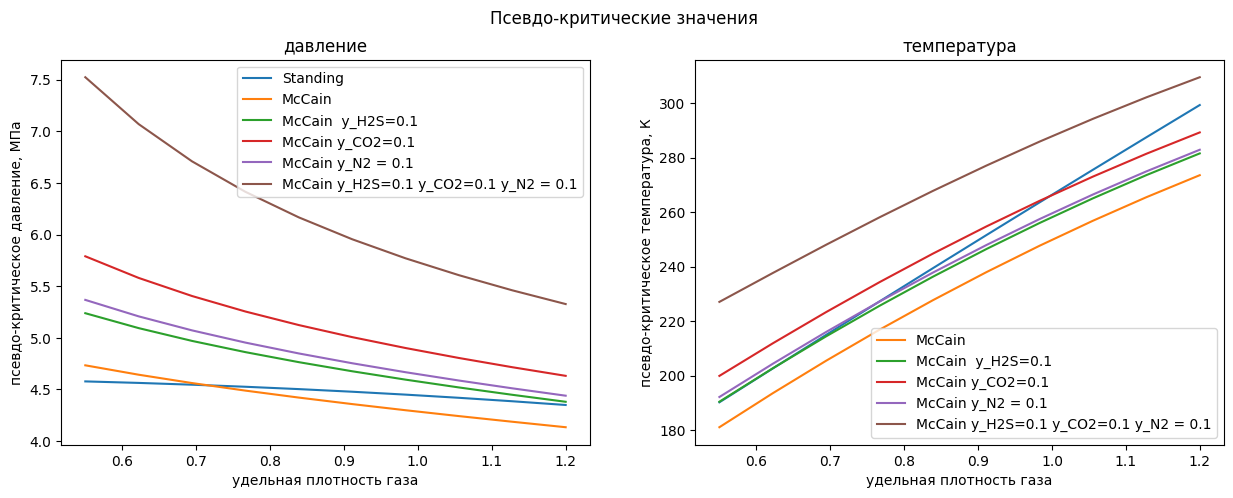

In [2]:
"""
Нарисуем графики псевдо критического давления и температуры от плотности газа

чтобы оценить диапазоны изменения псевдо критических параметров
с учетом наличия примесей
"""

gg_list = np.linspace(0.55, 1.2, 10)  # 0.55 плотность метана, вряд ли углеводородный газ будет легче

p_crit_list = [pvtg.unf_pseudocritical_pressure_Standing_MPa(gg) for gg in gg_list]
t_crit_list = [pvtg.unf_pseudocritical_temperature_Standing_K(gg) for gg in gg_list]

y_h2s:float=[0, 0.1]
y_co2:float=[0, 0.1]
y_n2:float=[0, 0.1]

p_crit_list_impurities={}
t_crit_list_impurities={}
label_impurities={}

p_crit_list_impurities[1] = [pvtg.unf_pseudocritical_pressure_MPa(gg, y_h2s[0], y_co2[0], y_n2[0]) for gg in gg_list]
t_crit_list_impurities[1] = [pvtg.unf_pseudocritical_temperature_K(gg, y_h2s[0], y_co2[0], y_n2[0]) for gg in gg_list]
label_impurities[1]='McCain'

p_crit_list_impurities[2] = [pvtg.unf_pseudocritical_pressure_MPa(gg, y_h2s[1], y_co2[0], y_n2[0]) for gg in gg_list]
t_crit_list_impurities[2] = [pvtg.unf_pseudocritical_temperature_K(gg,y_h2s[1], y_co2[0], y_n2[0]) for gg in gg_list]
label_impurities[2]='McCain  y_H2S=0.1'

p_crit_list_impurities[3] = [pvtg.unf_pseudocritical_pressure_MPa(gg, y_h2s[0], y_co2[1], y_n2[0]) for gg in gg_list]
t_crit_list_impurities[3] = [pvtg.unf_pseudocritical_temperature_K(gg, y_h2s[0], y_co2[1], y_n2[0]) for gg in gg_list]
label_impurities[3]='McCain y_CO2=0.1'

p_crit_list_impurities[4] = [pvtg.unf_pseudocritical_pressure_MPa(gg, y_h2s[0], y_co2[0], y_n2[1]) for gg in gg_list]
t_crit_list_impurities[4] = [pvtg.unf_pseudocritical_temperature_K(gg, y_h2s[0], y_co2[0], y_n2[1]) for gg in gg_list]
label_impurities[4]='McCain y_N2 = 0.1'

p_crit_list_impurities[5] = [pvtg.unf_pseudocritical_pressure_MPa(gg, y_h2s[1], y_co2[1], y_n2[1]) for gg in gg_list]
t_crit_list_impurities[5] = [pvtg.unf_pseudocritical_temperature_K(gg, y_h2s[1], y_co2[1], y_n2[1]) for gg in gg_list]
label_impurities[5]='McCain y_H2S=0.1 y_CO2=0.1 y_N2 = 0.1'

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Псевдо-критические значения')
ax[0].plot(gg_list, p_crit_list, label = 'Standing' )
for k in p_crit_list_impurities.keys():
    ax[0].plot(gg_list, p_crit_list_impurities[k], label=label_impurities[k] )
ax[0].set(xlabel='удельная плотность газа', ylabel='псевдо-критическое давление, МПа')
ax[0].set_title('давление')
ax[0].legend()
ax[1].plot(gg_list, t_crit_list)
for k in t_crit_list_impurities.keys():
    ax[1].plot(gg_list, t_crit_list_impurities[k], label=label_impurities[k] )
ax[1].set(xlabel='удельная плотность газа', ylabel='псевдо-критическое температура, К')
ax[1].set_title('температура')
ax[1].legend()
plt.show()

Из графиков псевдо-критического давления и температуры видно, что критическое давление лежит в диапазоне от 40 до 50 бар, при наличии примесей в газе может значительно повышаться. При этом критическая температура лежит заметно ниже 273 К (0 С) для газов с плотностью менее 1 ($\gamma_{gas}<1$). Наличие примесей повышает критическую температуру, увеличение плотности также повышает критическую температуру.


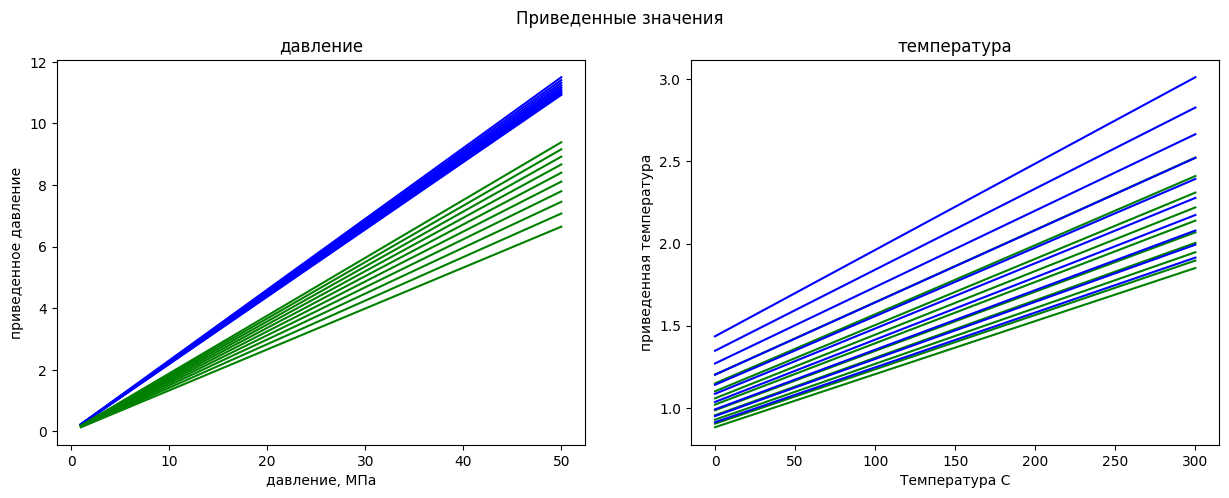

In [3]:
t_list_C = np.linspace(0, 300, 50)
t_list_K = t_list_C + 273
p_list_MPa = np.linspace(1,50, 50)

# нарисуем графики от давления

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle('Приведенные значения')
y_h2s:float=0.1
y_co2:float=0.1
y_n2:float=0.1

for gg in gg_list:
    p_crit_Mpa = pvtg.unf_pseudocritical_pressure_Standing_MPa(gg)
    t_crit_K = pvtg.unf_pseudocritical_temperature_Standing_K(gg)

    
    p_crit_list_impurities = pvtg.unf_pseudocritical_pressure_MPa(gg, y_h2s, y_co2, y_n2)
   
    
    ax[0].plot(p_list_MPa, p_list_MPa/p_crit_Mpa, color='blue')
    ax[0].plot(p_list_MPa, p_list_MPa/p_crit_list_impurities, color='green')

ax[0].set(xlabel='давление, МПа', ylabel='приведенное давление')
ax[0].set_title('давление')
#ax[0].legend()


#gg_list = [1, 1.2]
for gg in gg_list:
    p_crit = pvtg.unf_pseudocritical_pressure_Standing_MPa(gg)
    t_crit_K = pvtg.unf_pseudocritical_temperature_Standing_K(gg)
    
    
    t_crit_list_impurities = pvtg.unf_pseudocritical_temperature_K(gg, y_h2s, y_co2, y_n2) 
    ax[1].plot(t_list_K-273, t_list_K/t_crit_K, color='blue')
    ax[1].plot(t_list_K-273, t_list_K/t_crit_list_impurities, color='green')

ax[1].set(xlabel='Температура С', ylabel='приведенная температура')
ax[1].set_title('температура')
#ax[1].legend()
plt.show()

из графиков видо, что имеющие практический интерес значения приведенных давления и температуры лежат в диапазонах 
- по давлению от 0 до 12 МПа
- по температуре от 0.8 до 3

При этом надо отметить, что для приведенных температур около единицы могут быть сложности с расчетами по корреляциям. Реальный диапазон приведенных температур где расчет устойчив для большинства методов от 1.05 до 3. Расчеты в зоне критических температур (тяжелые газа, тяжелее воздуха или газы с большим количеством примесей) следует проводить с осторожностью.

# Графики Стендинга Катца

При проведении расчетов часто ориентируются для графики Стендинга Катца, полученные как обобщение экспериментальных данных для углеводородных газов.
[график Стендинга Катца на википедии](https://petrowiki.spe.org/File:Vol1_Page_225_Image_0001.png)
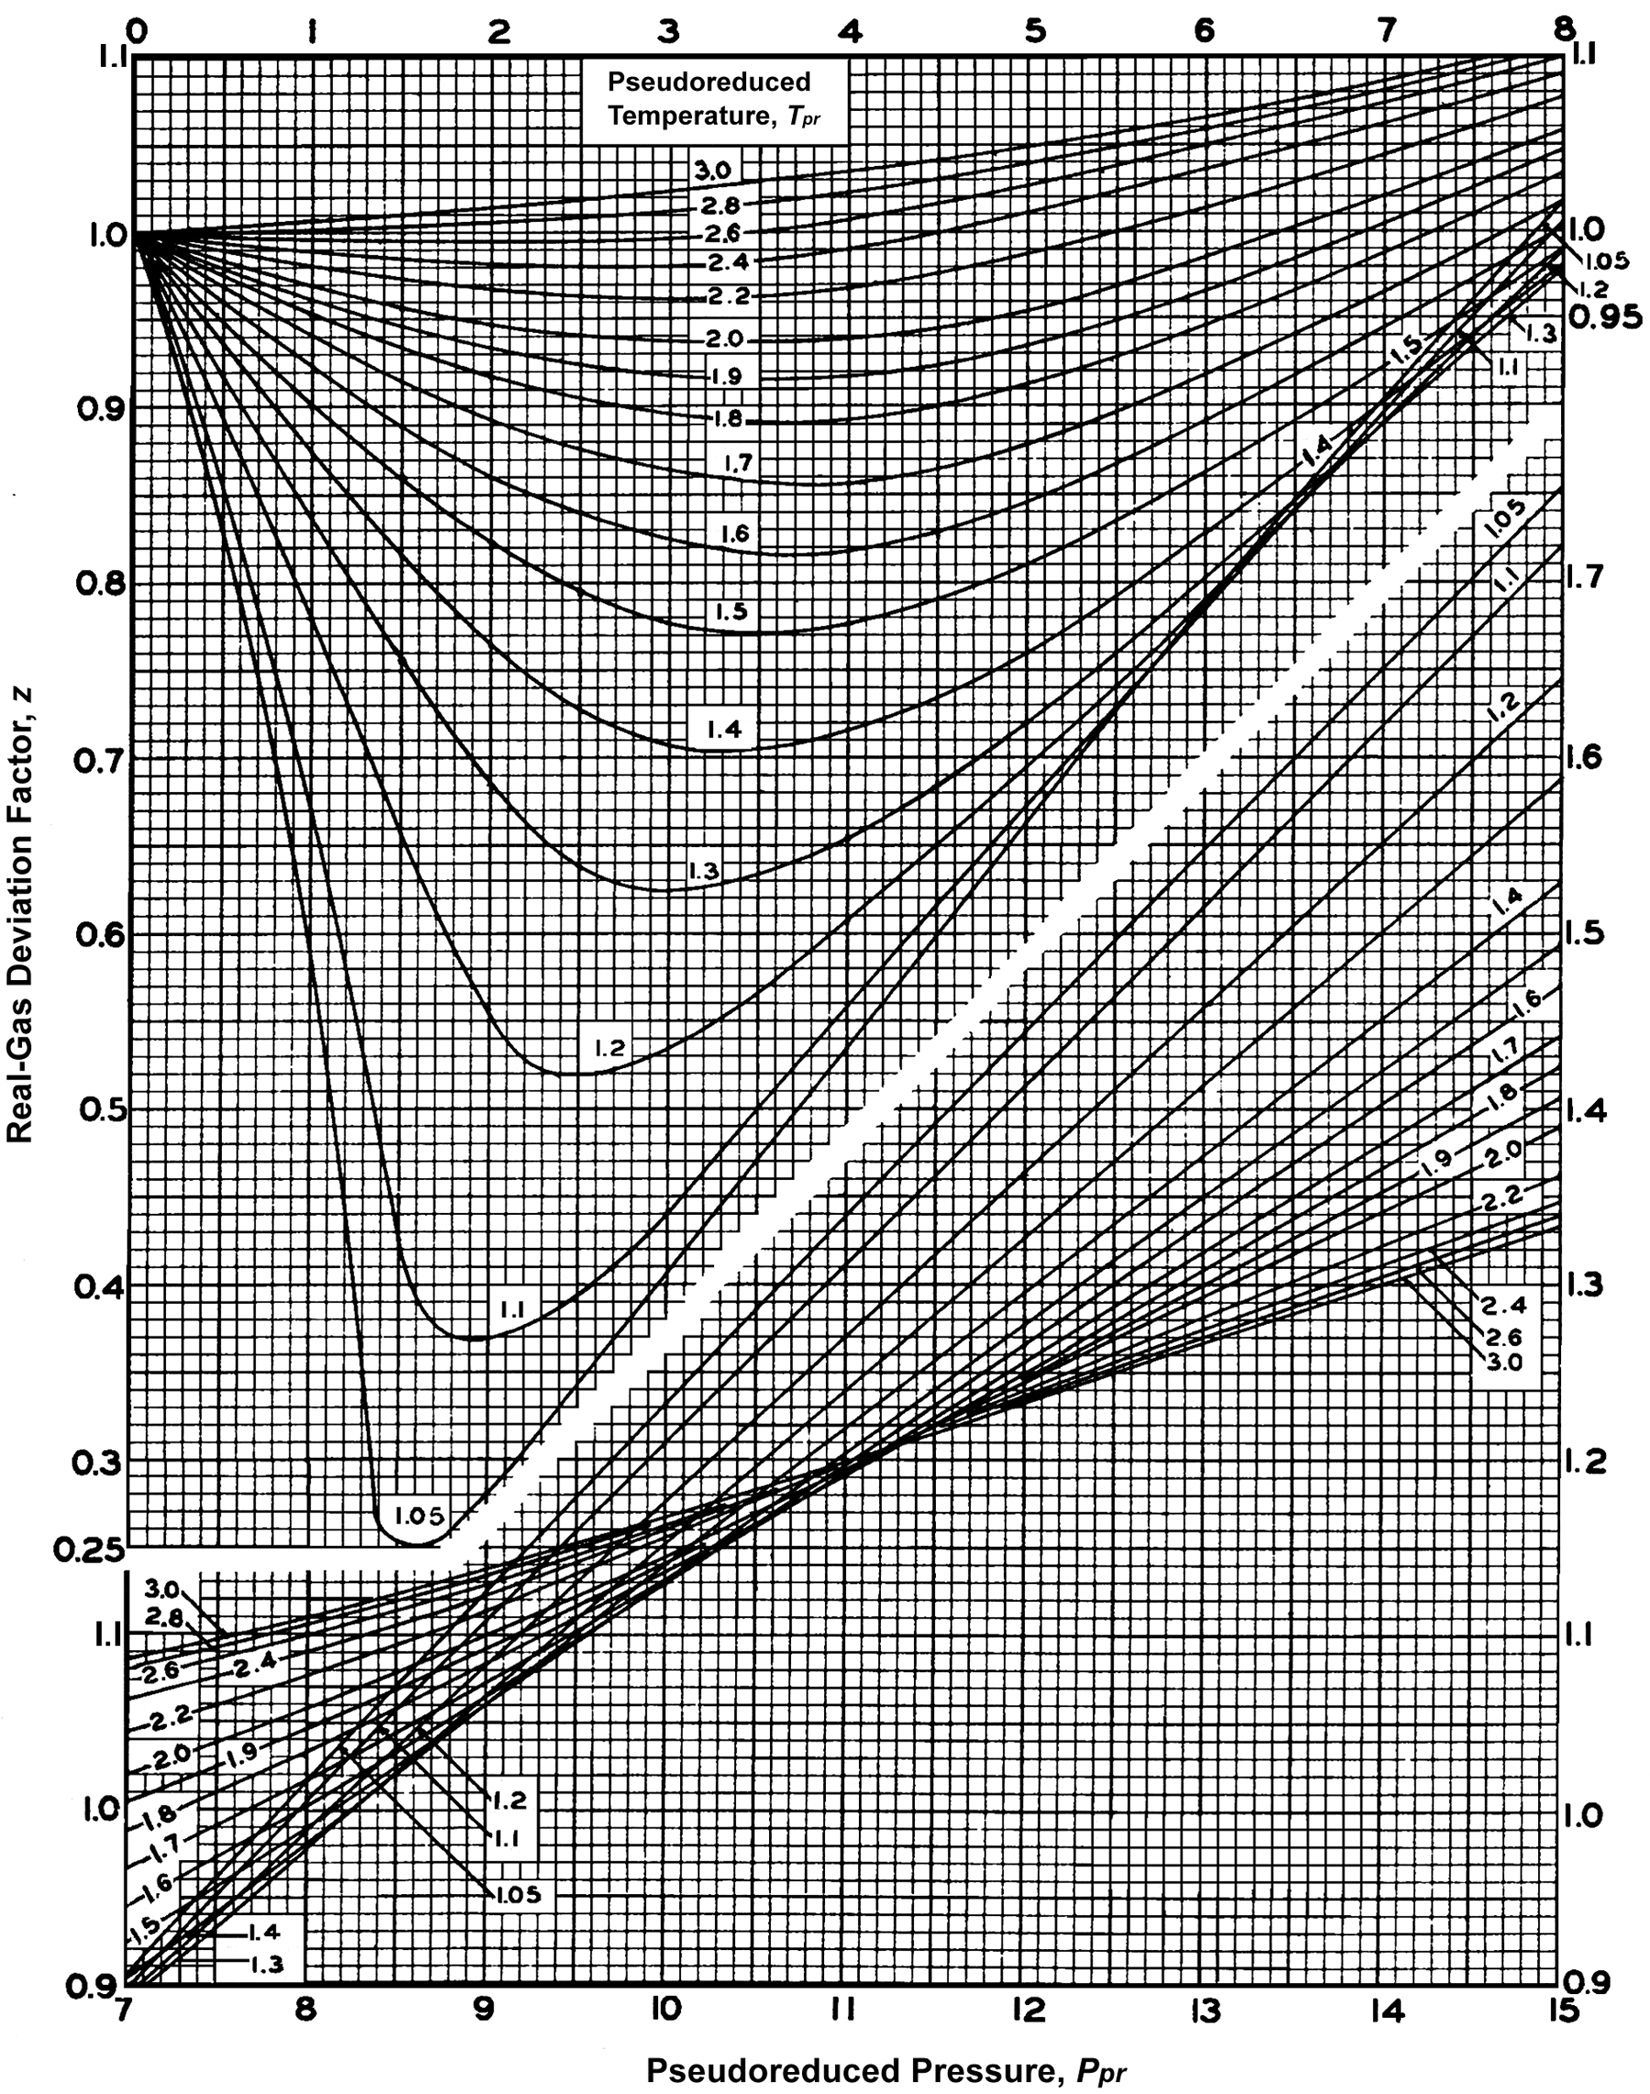

Многие корреляции пытаются созданы на основе этих графиков.

Полезно иметь возможность работать с оцифрованной версией графиков Стендинга Катца


In [4]:
def load_StandingKatz_curve():
    """
    загружает табулированные значения кривых с графика Standing Katz из набора файлов в папке data
    """
    with open(r'data\Standing_Katz_Chart_Data.json', 'r') as fp:
        dict_SK = json.load( fp)
    tpr = list(dict_SK.keys())
    
    df = pd.DataFrame()
    try:
        for k in dict_SK.keys():
            
            ppr = np.array(dict_SK[k]['ppr'])
            z = np.array(dict_SK[k]['z'])
            t = dict_SK[k]['tpr']
            df_SK_t = pd.DataFrame({f"tpr = {t}":z}, index = ppr)
            if df.shape[0]==0:
                df = df_SK_t.copy()
            else:
                df =df.join(df_SK_t, how='outer')
            df = df.sort_index().interpolate(method='index')
        # пробуем сделать интерполятор на регулярной сетке
        ppr = np.array(df.index)
        tpr = np.array(tpr)
        data = np.array(df)
        interp = RegularGridInterpolator((ppr, tpr), data,
                                         bounds_error=False, fill_value=None)
        return {'df':df, 'interp':interp}
    except Exception as e:
        print(e)

# можно получить таблицу данных считанных непосредственно с графика Стендинга Катца
StandingKatz_curve = load_StandingKatz_curve()
df = StandingKatz_curve['df']

<Axes: title={'center': 'График Стендинга Катца оцифрованный'}, xlabel='$p_{pr}$', ylabel='z'>

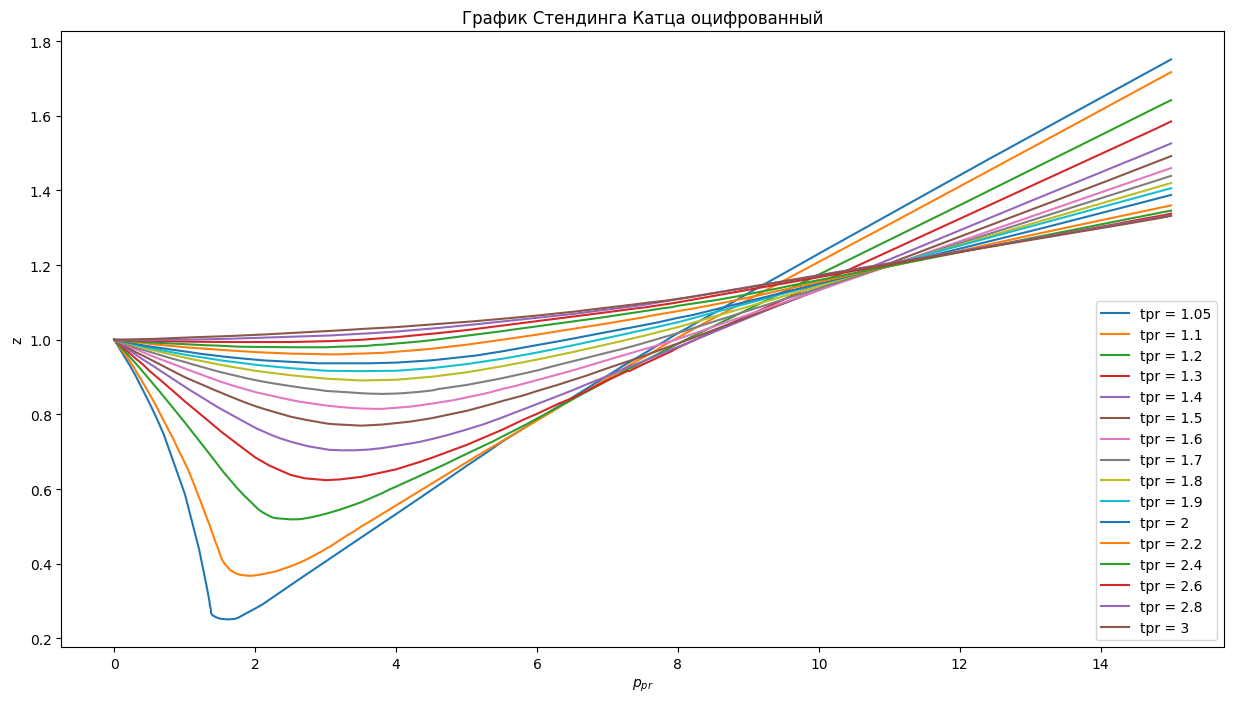

In [5]:

df.plot(figsize=(15,8), title='График Стендинга Катца оцифрованный', xlabel='$p_{pr}$', ylabel='z')

In [6]:
# можно получить функцию интеполирующую (и экстрполирующую) считанную таблицу
interp_SK = StandingKatz_curve['interp']

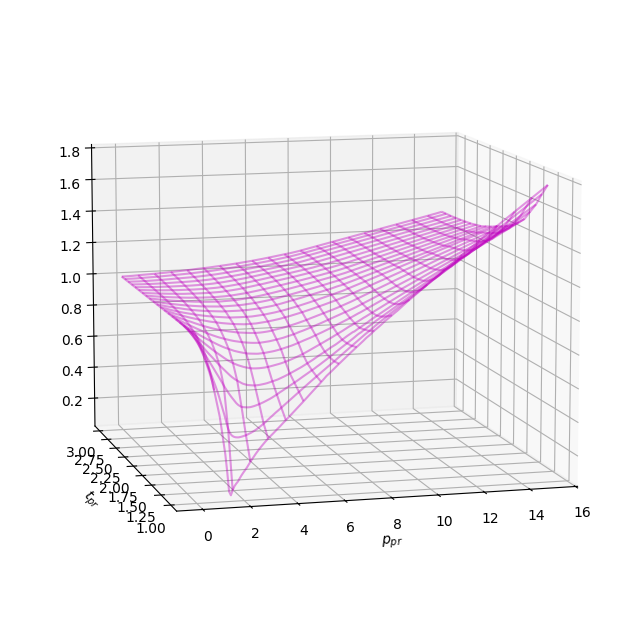

In [7]:
# трехмерное представление считанной таблицы
X, Y = np.meshgrid(np.linspace(0,15,200), 
                   np.linspace(1,3,200), 
                   indexing='ij')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10, azim=-105, roll=0)
ax.plot_wireframe(X, Y, interp_SK((X,Y)), rstride=10, cstride=10,
                  alpha=0.4, color='m', label='linear interp')
ax.set_xlabel('$p_{pr}$')
ax.set_ylabel('$t_{pr}$')

plt.show()

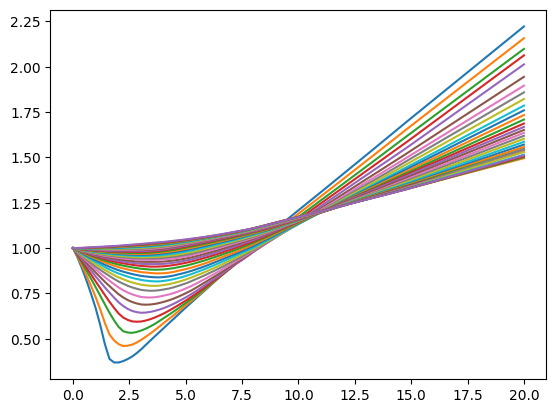

In [8]:
tpr = np.linspace(1.1,3,35)
ppr = np.linspace(0, 20, 100)
for t in tpr:
    plt.plot(ppr, interp_SK((ppr, t)))
plt.show()

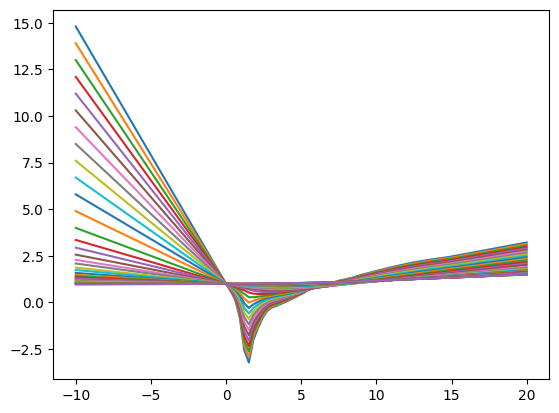

In [9]:
# экстраполяция в область приведенных температур менее 1 и отрицательных давлений может приводить к странным результатам
# исходный диапазон построение данных по графику Стендинга Катца tpr от 1.05 до 3, по ppr от 0 до 15!

tpr = np.linspace(0,3,35)
ppr = np.linspace(-10, 20, 100)
for t in tpr:
    plt.plot(ppr, interp_SK((ppr, t)))
plt.show()

#  DAK  Dranchuk Abu Kassem
Источник: Dranchuk P. M. et al. Calculation of Z factors for natural gases using equations of state //Journal of Canadian Petroleum Technology. – 1975. – Т. 14. – №. 03.

Коэффициент сверхсжимаемости учитывает отклонение свойств реального газа от идеального.

Dranchuk P. M. et al. получили уравнение состояния реального газа адаптировав его к экспериментальным данным Stending and Katz

$$Z = 1 + 
(A_1 +\frac{A_2}{T_r} +\frac{A_3}{T_{r}^3} +\frac{A_4}{T_{r}^4} +\frac{A_5}{T_{r}^5})\rho_{r} + 
(A_6 +\frac{A_7}{T_{r}^2} +\frac{A_8}{T_{r}^8})\rho_{r}^2 - 
A_9(\frac{A_7}{T_{r}} +\frac{A_6}{T_{r}^2})\rho_{r}^5 - 
A_{10} (1 + A_{11} \rho_{r}^2) \frac{\rho_{r}^2}{T_{r}^3}exp(-A_{11}\rho_{r}{2})$$
где:
$$\rho_r = \frac{Z_c P_r}{Z T_r}$$
причем:
$$Z_c = 0.27$$
коэффициенты:
$$A_1 =0.3265$$
$$A_2 =-1.0700$$
$$A_3 =-0.5339$$
$$A_4 =0.01569$$
$$A_5 =-0.05165$$
$$A_6 =0.5475$$
$$A_7 =-0.7361$$
$$A_8 =0.1844$$
$$A_{9} =0.1056$$
$$A_{10} =0.6134$$
$$A_{11} =0.7210$$
а приведенные давление и температура:
$$P_{r} = \frac{P}{P_c}$$
$$T_{r} = \frac{T}{T_c}$$
где $p_c$ и $T_c$ критические давление и температура соответственно

Dranchuk and Abou-Kassem[8] found an average absolute error of 0.486% in their equation, with a standard deviation of 0.00747 over ranges of pseudoreduced pressure and temperature of 0.2 < ppr < 30; 1.0 < Tpr < 3.0; and for ppr < 1.0 with 0.7 < Tpr < 1.0.

Dranchuk and Abou-Kassem[8] also found that this equation and other equations of state give unacceptable results near the critical temperature for Tpr = 1.0 and ppr >1.0, so these equations are not recommended in this range.

In [10]:
def unf_zfactor_DAK_ppr_(ppr:float, tpr:float)->float:
    """
        Correlation for z-factor

    :param ppr: pseudoreduced pressure
    :param tpr: pseudoreduced temperature
    :return: z-factor

    range of applicability is (0.2<=ppr<30 and 1.0<tpr<=3.0) and also ppr < 1.0 for 0.7 < tpr < 1.0

    ref 1 Dranchuk, P.M. and Abou-Kassem, J.H. “Calculation of Z Factors for Natural
    Gases Using Equations of State.” Journal of Canadian Petroleum Technology. (July–September 1975) 34–36.

    """
    #print(ppr, tpr)
    #if tpr<1.06:
    #    tpr=1.06
    z0 = 1
    ropr0 = 0.27 * (ppr / (z0 * tpr))

    def f(z):
        #z, ropr = variables
        #func = np.zeros(2)
        ropr = 0.27 * (ppr / (z * tpr)) 
        func = -z + 1 + \
                (0.3265 - 1.0700 / tpr - 0.5339 / tpr**3 + 0.01569 / tpr ** 4 - 0.05165 / tpr ** 5) * ropr +\
                (0.5475 - 0.7361 / tpr + 0.1844 / tpr ** 2) * ropr ** 2 - \
                0.1056 * (-0.7361 / tpr + 0.1844 / tpr ** 2) * ropr ** 5 + \
                0.6134 * (1 + 0.7210 * ropr ** 2) * (ropr ** 2 / tpr ** 3) * np.exp(-0.7210 * ropr ** 2)
        #print(z, func)
        return func
    #solution = opt.fsolve(f, np.array([z0]))
    #solution = opt.newton(f, z0, maxiter=150, tol=1e-5)
    solution = opt.root_scalar(f,  method='bisect', bracket=(0.1, 5))
    """
    solution = opt.fsolve(f, np.array([z0]))
    """
    return solution.root

In [11]:
unf_zfactor_DAK_ppr_(2.7, 1.03)

0.4051896343691851

In [12]:
unf_zfactor_DAK_ppr = np.vectorize(unf_zfactor_DAK_ppr_)

unf_z_factor_Kareem =  np.vectorize(pvtg.unf_z_factor_Kareem)

Сравнение экспериментального графика Стендинга-Каци и уравнения Дранчука и Абу-Кассема

In [13]:
unf_zfactor_DAK_ppr(np.array([2,3]), np.array([2,3]))

array([0.94593435, 1.0113074 ])

In [14]:
unf_z_factor_Kareem(np.array([2,3]), np.array([1,3]))

array([0.96840286, 1.01156766])

C:\unifloc\neftpy\notebooks\..\neftpy\upvt_gas.py:289: RuntimeWarning: invalid value encountered in scalar divide
  z = DPpr * (1 + y + y ** 2 - y ** 3) / (DPpr + EE * y ** 2 - FF * y ** GG) / ((1 - y) ** 3)


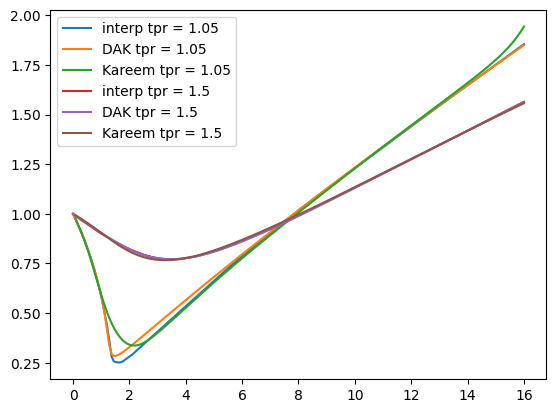

In [17]:
tpr = 1.05
ppr = np.linspace(0, 16, 200)

z1 = interp_SK((ppr, tpr))
z2 = unf_zfactor_DAK_ppr(ppr, tpr)
z3 = unf_z_factor_Kareem(tpr, ppr)

plt.plot(ppr, z1, label='interp tpr = 1.05')
plt.plot(ppr, z2, label='DAK tpr = 1.05')
plt.plot(ppr, z3, label='Kareem tpr = 1.05')

tpr = 1.5

z1 = interp_SK((ppr, tpr))
z2 = unf_zfactor_DAK_ppr(ppr, tpr)
z3 = unf_z_factor_Kareem(tpr, ppr)

plt.plot(ppr, z1, label='interp tpr = 1.5')
plt.plot(ppr, z2, label='DAK tpr = 1.5')
plt.plot(ppr, z3, label='Kareem tpr = 1.5')

plt.legend()
plt.show()

In [19]:
%timeit z1 = interp_SK((ppr, tpr))
%timeit z2 = unf_zfactor_DAK_ppr(ppr, tpr)
%timeit z3 = unf_z_factor_Kareem(tpr, ppr)

89.2 µs ± 774 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
45 ms ± 994 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.44 ms ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
